## Goal
- Implement classification with resnet18 in tinyImagenet dataset using d2l library
    - Wrap tiny imagenet data under d2l library
    - Fit with GPU
    - Record validation losses, accuracy, time taken to train

In [2]:
import torch
import time
import d2l.torch as d2l
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
from torchvision.models import resnet18
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Image
import json
import requests
from data import TinyImageNet
import collections
from IPython import display

In [3]:
batch_size = 256
num_workers = 2
learning_rate = 0.01
num_epochs = 20
device = d2l.try_gpu()
device

device(type='cuda', index=0)

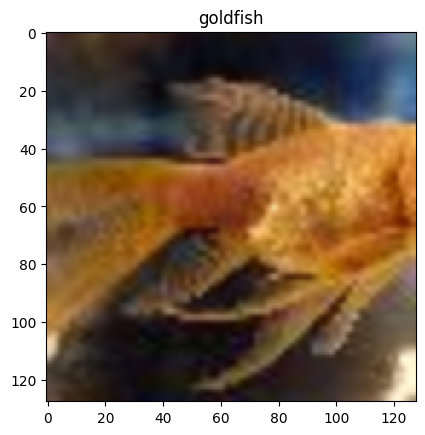

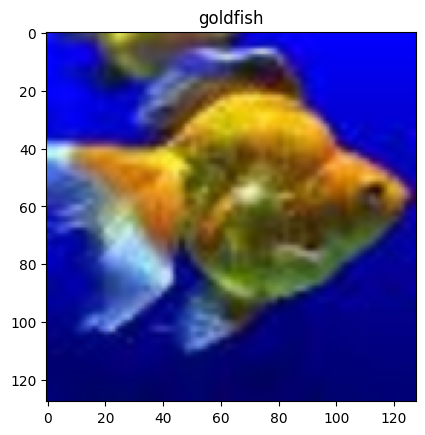

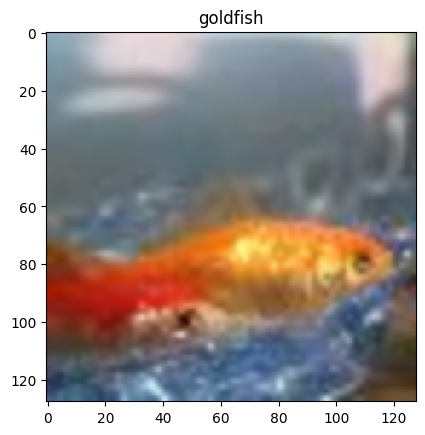

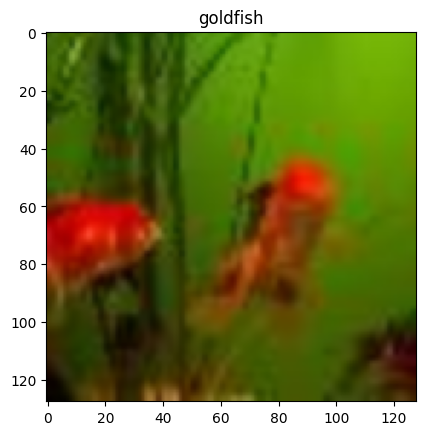

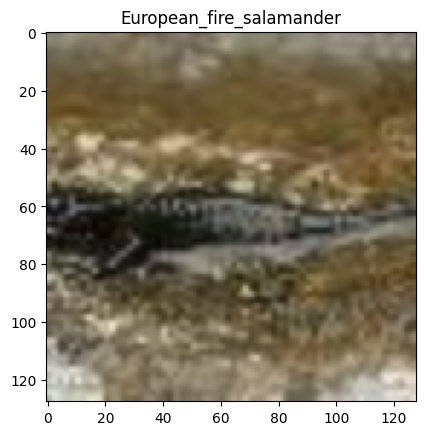

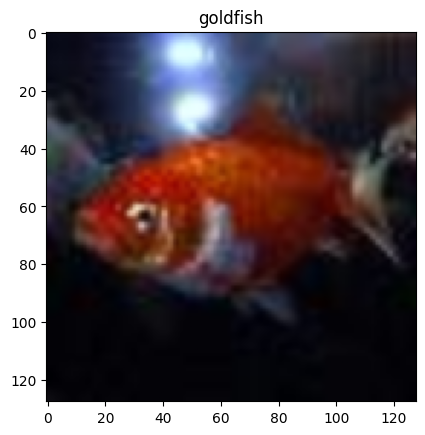

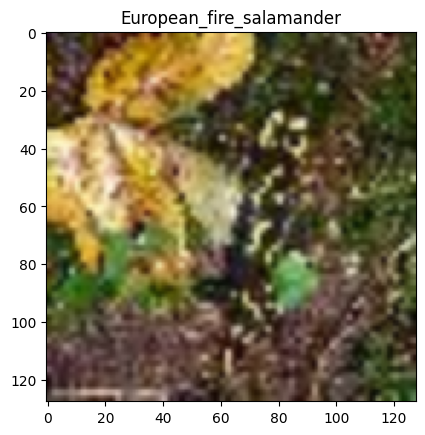

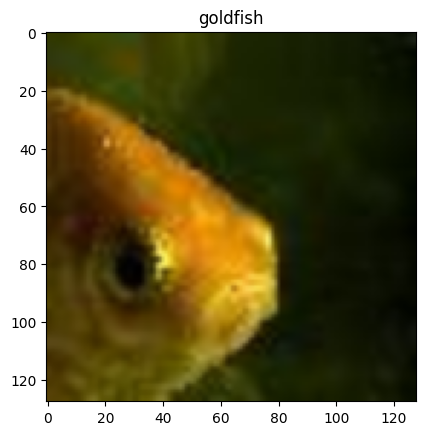

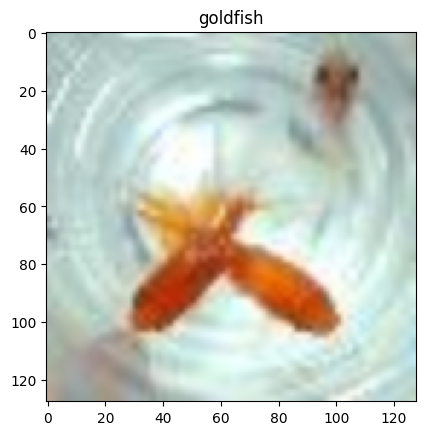

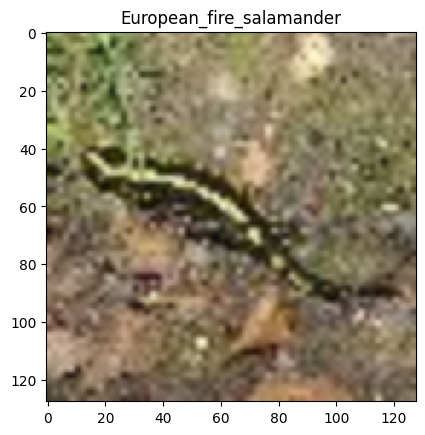

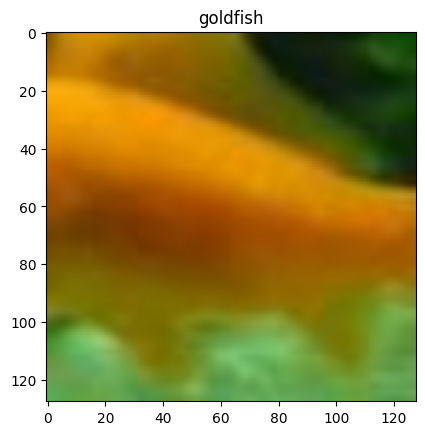

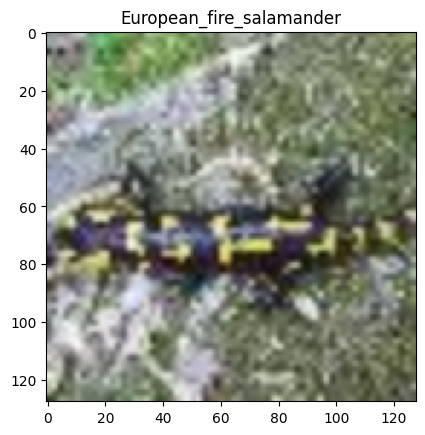

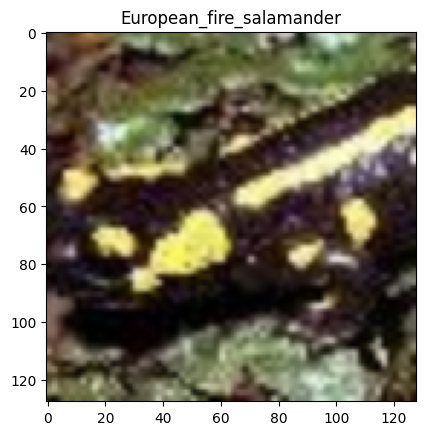

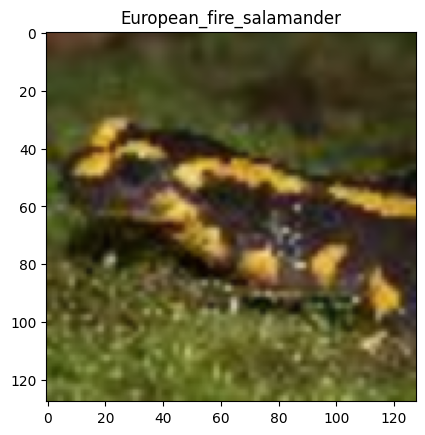

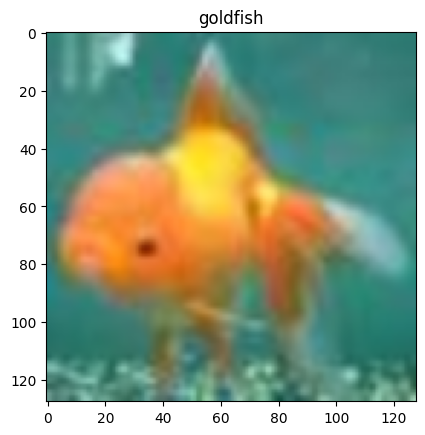

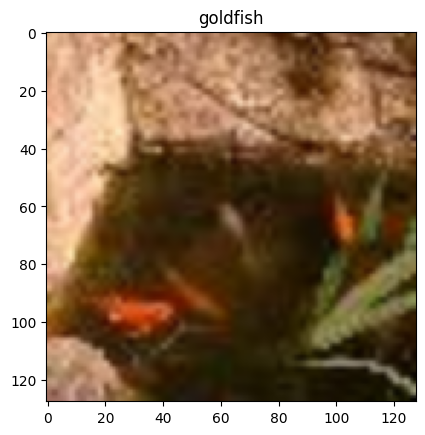

In [ ]:
tiny_imagenet = TinyImageNet( )


In [4]:
from collections import defaultdict

class ResnetD2l(d2l.Classifier):
    def __init__(self, num_classes, pretrained=False, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = resnet18(pretrained=pretrained)
        self.net.fc = nn.Linear(512, num_classes)
        self.board = d2l.ProgressBoard()
        self.metrics = defaultdict(lambda : {"train" : [], "val" : [], "figure" : None, "subplot" : None})
        self.figsize = (10, 5)

        def init_weights(m):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                nn.init.xavier_uniform_(m.weight)
        self.net.apply(init_weights)
    
    def forward(self, x):
        return self.net(x)
    
    def loss(self, y_hat, y):
        return nn.CrossEntropyLoss()(y_hat, y)

In [5]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    x = batch['image']
    y = batch['label']
    return (x.to(self.device), y.to(self.device))

@d2l.add_to_class(d2l.Classifier)
def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    val_loss = self.loss(Y_hat, batch[-1])
    val_acc = self.accuracy(Y_hat, batch[-1])
    self.metrics['loss']['val'].append(val_loss.item())
    self.metrics['accuracy']['val'].append(val_acc.item())
    self.plot('loss', val_loss, train=False)
    self.plot('accuracy', val_acc, train=False)

@d2l.add_to_class(d2l.Classifier)
def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    acc = self.accuracy(self(*batch[:-1]), batch[-1])
    self.metrics['loss']['train'].append(l.item())
    self.metrics['accuracy']['train'].append(acc.item())
    self.plot('loss', l, train=True)
    self.plot('accuracy', acc, train=True)
    return l

@d2l.add_to_class(d2l.Classifier)
def display_metrics(self, num_training_batches, num_val_batches):
    for key, value in self.metrics.items():
        train_metric = self.get_running_mean(value['train'], num_training_batches)
        val_metric = self.get_running_mean(value['val'], num_val_batches)
        print(f'{key} - train: {train_metric}, val: {val_metric}')

@d2l.add_to_class(d2l.Classifier)
def get_running_mean(self, values, num_batches):
    return np.mean(values[-num_batches:])

loss - train: 0.23475968483835458, val: 0.7156440868973732
accuracy - train: 0.9561573937535286, val: 0.8054999887943268


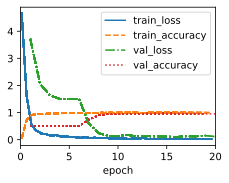

In [6]:

data = TinyImagenetD2l(batch_size, num_workers, is_toy=True)
num_training_batches = len(data.train_data)
num_val_batches = len(data.val_data)
model = ResnetD2l(num_classes=data.num_classes, pretrained=False, lr=learning_rate)
model.to(device)

trainer = d2l.Trainer(max_epochs=num_epochs, num_gpus=1)
trainer.device = device
trainer.fit(model=model, data=data)

model.display_metrics(num_training_batches, num_val_batches)




loss - train: 0.36623709911946206, val: 1.0459289595484733
accuracy - train: 0.9157512791454792, val: 0.7704999834299088


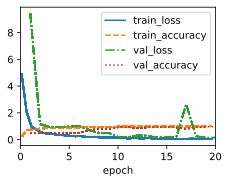

In [7]:

data = TinyImagenetD2l(batch_size, num_workers, is_toy=True)
num_training_batches = len(data.train_data)
num_val_batches = len(data.val_data)
model = ResnetD2l(num_classes=data.num_classes, pretrained=True, lr=learning_rate)
model.to(device)

trainer = d2l.Trainer(max_epochs=num_epochs, num_gpus=1)
trainer.device = device
trainer.fit(model=model, data=data)

model.display_metrics(num_training_batches, num_val_batches)


